# Analyse des données relatives à la dystrophie de Fuchs

## Chargement de la base de données

In [195]:
from image_OCT import *
from image_Quantification import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate
import os
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
import math 
import seaborn as sns
from sklearn import datasets, svm

data_healthy = pd.read_pickle("./Dataset/data_set_healthy.pkl")
data_fuchs = pd.read_pickle("./Dataset/data_set_fuchs.pkl")
data_learning = pd.read_pickle("./Dataset/data_set_learning_small.pkl")
data_healthy

,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,Healthy,Origin
0,0.923148,0.192947,0.010370,0.486650,0.038216,0.023583,1,ARAILI_OS_Line
1,0.923148,0.215471,0.003818,0.521991,0.027520,0.016452,1,ARAILI_OS_Pachy
2,1.384722,0.204899,0.006951,0.609912,0.075543,0.020033,1,BEGABD_OD_Cross
3,1.384722,0.184589,0.007035,0.648135,0.076352,0.018449,1,BEGABD_OD_Pachy
4,1.384722,0.190988,0.007933,0.628456,0.088622,0.020435,1,BEGABD_OS_Cross
...,...,...,...,...,...,...,...,...
137,1.384722,0.222632,0.004758,0.563157,0.064476,0.022139,1,TOUMAT_OS_Cross
138,0.923148,0.202665,0.003875,0.547548,0.035856,0.018839,1,TOUMAT_OS_Pachy
139,0.923148,0.209607,0.002006,0.534759,0.019756,0.012935,1,WIETIP_OD_Line
140,0.923148,0.194756,0.002725,0.414720,0.029858,0.007072,1,WIETIP_OS_Line


In [196]:
month=np.ones(len(data_fuchs))*np.nan
id=[]
type=[]
for i in range(len(data_fuchs)):
    origin=data_fuchs["Origin"][i]
    origin_split=origin.split("_")
    month[i]=int(origin_split[2])
    id.append(origin_split[0]+"_"+origin_split[1])
    type.append(origin_split[3])
id=np.array(id)
type=np.array(type)
data_fuchs=data_fuchs.assign(Month=month)
data_fuchs=data_fuchs.assign(Id=id)
data_fuchs=data_fuchs.assign(Type=type)
data_fuchs.to_pickle("./Dataset/data_set_fuchs.pkl")

In [197]:
data_fuchs

,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,Healthy,Origin,Month,Id,Type
0,1.384722,0.258755,0.000937,0.773321,0.050214,0.019196,2,BARVER_OD_0_Line,0.0,BARVER_OD,Line
1,1.846296,0.458977,0.002127,1.048359,0.119122,0.020066,2,BARVER_OD_0_Pachy,0.0,BARVER_OD,Pachy
2,2.769444,0.640778,0.004447,1.272999,0.127240,0.035296,2,BARVER_OD_12_Line,12.0,BARVER_OD,Line
3,2.307870,0.590739,0.002377,1.063431,0.100026,0.028965,2,BARVER_OD_12_Pachy,12.0,BARVER_OD,Pachy
4,2.307870,0.522643,0.003247,1.038623,0.061781,0.021845,2,BARVER_OD_1_Line,1.0,BARVER_OD,Line
...,...,...,...,...,...,...,...,...,...,...,...
277,1.846296,0.493319,0.000048,1.045214,0.014399,0.004149,2,VANMAR_OD_0_Pachy,0.0,VANMAR_OD,Pachy
278,2.307870,0.398565,0.000289,1.055040,0.022788,0.011462,2,WEIELI_OS_0_Line,0.0,WEIELI_OS,Line
279,2.776492,0.544895,0.000839,1.391041,0.028198,0.018346,2,WEIELI_OS_0_PachyWide,0.0,WEIELI_OS,PachyWide
280,1.384722,0.281189,0.002131,0.648678,0.082516,0.027785,2,WEIELI_OS_9_Line,9.0,WEIELI_OS,Line


## Représentation des données

In [198]:
id_list=np.unique(data_fuchs["Id"])
target_type="Pachy"
quantifier="Sigma"
values=[]
for id in id_list:
    positions=np.where(data_fuchs["Id"]==id)[0]
    positions=positions[np.where(data_fuchs["Type"][positions]==target_type)[0]]
    subdata=(data_fuchs.T[positions]).T
    arg=np.array(np.argsort(subdata["Month"]))
    arg=positions[arg]
    # print("Arg",arg,"*")
    if len(arg)>=3:
        # print(subdata["Month"])
        X=np.array(subdata["Month"][arg].T)
        Y=np.array(subdata[quantifier][arg].T)
        ids=np.array(subdata["Id"][arg].T)
        value={
            "Months":X,
            "Sigmas":Y,
            "Id":ids[0]
        }
        values.append(value)
data_Line_time=pd.DataFrame(values) 

Nulmber of patients:25


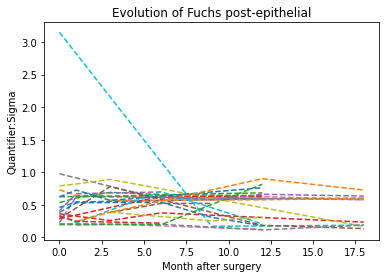

In [199]:
print("Nulmber of patients:"+str(len(data_Line_time)))
for i in range(len(data_Line_time)):
	plt.plot(data_Line_time["Months"][i],data_Line_time["Sigmas"][i],'--',label=data_Line_time["Id"][i])
plt.xlabel("Month after surgery")
plt.ylabel("Quantifier:"+quantifier)
plt.title("Evolution of Fuchs post-epithelial")
plt.show()

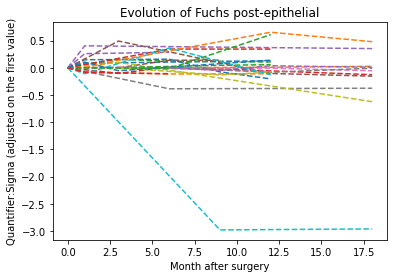

In [200]:
for i in range(len(data_Line_time)):
	plt.plot(data_Line_time["Months"][i],data_Line_time["Sigmas"][i]-data_Line_time["Sigmas"][i][0],'--',label=data_Line_time["Id"][i])
plt.xlabel("Month after surgery")
plt.ylabel("Quantifier:"+quantifier+" (adjusted on the first value)")
plt.title("Evolution of Fuchs post-epithelial")
plt.show()